In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

### You may need to clone the latest version of [pyathena](https://github.com/changgoo/pyathena)

In [2]:
# %load ../pyathena/dump_zprof.py
import pandas as pd
import pyathena as pa
import pickle as p
import os
import numpy as np
import xarray as xr

from pyathena import ath_hst

import glob
import argparse

# astropy
import astropy.constants as c
import astropy.units as u

solar_param={'surf_s':42*u.M_sun/u.pc**2,
            'rho_dm':0.0064*u.Msun/u.pc**3,
            'z0': 0.245*u.kpc,
            'R0': 8*u.kpc,}

class tigress_extpot(object):
    def __init__(self,param=solar_param):
        self.surf_s=param['surf_s']
        self.rho_dm=param['rho_dm']
        self.z0=param['z0']
        self.R0=param['R0']
        
    def gext(self,z):

        a1=2*np.pi*c.G*self.surf_s
        a2=4*np.pi*c.G*self.rho_dm
        g1=-a1*z/np.sqrt(z**2+self.z0**2)
        g2=-a2*z/(z**2/self.R0**2+1)
        g_new=g1+g2
    
        return g_new

    def phiext(self,z):
        phi=2*np.pi*c.G*(self.surf_s*(np.sqrt(z**2+self.z0**2)-self.z0)
                         +self.rho_dm*self.R0**2*np.log(1+z**2/self.R0**2))
        return phi
    
    def vesc(self,z):
        return np.sqrt(2*(self.phiext(z.max()).to('km^2/s^2')-self.phiext(z).to('km^2/s^2')))

def parse_par(rstfile):

    fp=open(rstfile,'rb')
    par={}
    line=fp.readline().decode('utf-8')

    while 1:

        if line.startswith('<'):
            block=line[1:line.rfind('>')]
            if block == 'par_end': break
            par[block]={}
        line=fp.readline().decode('utf-8')

        if block in ['problem','domain1','time']:
            sp = line.strip().split()
            if len(sp) >= 3: par[block][sp[0]]=eval(sp[2])
        else:
            sp=line.split('=')
            if len(sp) == 2: par[block][sp[0].strip()]=sp[1].split('#')[0].strip()

    par[block]=fp.tell()

    fp.close()

    return par

def set_field_list(par):
    zprof_flist=['P']
    zprof_flist+=['pP','mP']
            
    return zprof_flist

def get_configure(par):
    shearing_box=False
    if par['configure']['ShearingBox'] == 'yes': shearing_box=True 
    cooling=False
    if par['configure']['cooling'] == 'ON': cooling=True
    MHD=False
    if par['configure']['gas'] == 'mhd': MHD=True
    nscalar = eval(par['configure']['nscalars'])
    Gamma=par['problem']['gamma']
    return shearing_box,cooling,MHD,nscalar,Gamma

def get_zprof(data,domain,par,hst):
    import pyathena as pa
    coolftn=pa.coolftn()

    full_domain=get_full_domain(par)
    x,y,z,=pa.cc_arr(full_domain)
    
    v3=np.copy(data['velocity3'].data)
    P=np.copy(data['pressure'].data)
    T1=np.copy(data['T1'].data)

    zprof={}

    zprof['P']=P
    zprof['T']=coolftn.get_temp(T1)

    for pm in ['p','m']:
        zprof[pm+'P'] = np.copy(P)
        
    nv3=v3<0
    pv3=~nv3
    for k in zprof:
        if k.startswith('p'): zprof[k][nv3]=0
        if k.startswith('m'): zprof[k][pv3]=0
    
    dA=domain['dx'][0]*domain['dx'][1]
    zprof['A']=np.ones(P.shape)*dA
    
    return z,zprof

def get_phase(data):
    temp=data['T']

    idx={}
    idx['phase1']=temp < 184
    idx['phase2']=(temp >= 184) * (temp <5050)
    idx['phase3']=(temp >= 5050) * (temp <2.e4)
    idx['phase4']=(temp >= 2.e4) * (temp <5.e5)
    idx['phase5']=temp >= 5.e5
    return idx

def get_mean(dset,dA):
    
    zp=dset.sum(dim=['x','y'])*dA

    return zp

def get_full_domain(par):
    full_domain={}
    full_domain['left_edge']=np.array([par['domain1']['x1min'],par['domain1']['x2min'],par['domain1']['x3min']]).astype('float')
    full_domain['right_edge']=np.array([par['domain1']['x1max'],par['domain1']['x2max'],par['domain1']['x3max']]).astype('float')
    full_domain['Nx']=np.array([par['domain1']['Nx1'],par['domain1']['Nx2'],par['domain1']['Nx3']])
    full_domain['Lx']=full_domain['right_edge']-full_domain['left_edge']
    full_domain['dx']=full_domain['Lx']/full_domain['Nx']
    return full_domain

def dump_zprof_one(f,dc,icm_field=None,outdir='zprof_icm',
                   plist=['phase1','phase2','phase3','phase4','phase5']):
    par=dc.par
    hst=dc.hst

    flist=set_field_list(par)
    full_domain=get_full_domain(par)
    x,y,z,=pa.cc_arr(full_domain)

    icm=False
    if icm_field is not None: icm=True

    print('\nReading: ',f)

    ds = pa.AthenaDataSet(f)
    time = ds.domain['time']

    zp_slab=[]
    if icm: zp_slab_icm=[]
    print('Calculating zprof...') 
    for islab in range(ds.NGrids[2]):
        print('{}/{}'.format(islab,ds.NGrids[2]),end=' ')
        grids=ds._get_slab_grid(islab+1,verbose=False)
        slab_domain=ds._setup_domain(grids)
        xs,ys,zs,=pa.cc_arr(slab_domain)
        data=xr.Dataset()
        for fi in ['velocity3','pressure','T1']:
            slab_data=ds.read_all_data(fi,slab=islab+1)
            if slab_data.ndim == 4:
                for ivec in [1,2,3]:
                    data['{}{}'.format(fi,ivec)]=xr.DataArray(slab_data[...,ivec-1],
                                                              dims=['z','y','x'],
                                                              coords=[zs,ys,xs])
            else:
                data[fi]=xr.DataArray(slab_data,dims=['z','y','x'],coords=[zs,ys,xs])

        z_part,zpw_part=get_zprof(data,slab_domain,par,hst)
        dset=xr.Dataset()
        for field in zpw_part:
            dset[field]=xr.DataArray(zpw_part[field],
                                     dims=['z','y','x'],coords=[zs,ys,xs])

        idx=get_phase(dset)
        dA=float(dset['A'][0,0,0].data)
        zp_part=[]
        if icm: 
            ficm=np.clip(dset[icm_field]/dset['d'],0,1)
            zp_part_icm=[]

        for phase in plist:
            zidx_part=pd.Series(z_part,name='z')

            zp_part.append(get_mean(dset*idx[phase],dA).expand_dims('phase'))

            if icm: 
                zp_part_icm.append(get_mean(dset*idx[phase]*ficm,dA).expand_dims('phase'))
        zp_slab.append(xr.concat(zp_part,dim='phase'))
        if icm: zp_slab_icm.append(xr.concat(zp_part_icm,dim='phase'))

        for g in grids:
            g['data'].clear()

    zpds=xr.concat(zp_slab,dim='z')
    zpds.coords['phase']=plist
    zpds=zpds.rename(z='zaxis').expand_dims('taxis')
    zpds=zpds.assign_coords(taxis=[time])
    if icm: 
        zpds_icm=xr.concat(zp_slab_icm,dim='z')
        zpds_icm.coords['phase']=plist

#     dirname=dc.base+dc.pdir+outdir+'/'
#     fbase=os.path.basename(f)
#     print('\nWriting at {}: '.format(dirname))
#     for phase in plist:
#         print(phase,end=' ')
#         zprof_fname=dirname+fbase.replace('vtk','%s.zprof.P' % phase)
#         with open(zprof_fname,'w') as fp:
#             fp.write('# Athena vertical profile at t={}\n'.format(time))
#             zpdf=zpds.sel(phase=phase).drop('phase').to_dataframe()
#             zpdf.to_csv(fp)
#         if icm: 
#             zprof_fname_icm=dirname+fbase.replace('vtk','%s-icm.zprof' % phase)
#             with open(zprof_fname_icm,'w') as fp:
#                 fp.write('# Athena vertical profile at t={}\n'.format(time))
#                 zpdf=zpds_icm.sel(phase=phase).drop('phase').to_dataframe()
#                 zpdf.to_csv(fp)

    if icm: 
        return zpds,zpds_icm
    else:
        return zpds

class data_container(object):
    def __init__(self,pid,base='/tigress/changgoo/',pdir=None,vtkbase=None):
        if pdir is None: pdir=pid+'/'
        if vtkbase is None:
            self.vtkbase = base+pdir
        else:
            self.vtkbase = vtkbase 
        self.base=base
        self.pdir=pdir
        self.pid=pid
        self.vtkfiles= glob.glob(self.vtkbase+"id0/"+pid+".????.vtk")
        self.vtkfiles.sort() 
        self.parfname='%s%s/%s.par' % (base,pdir,pid)
        self.par=parse_par(self.parfname)
        self.hstfname='%s%s/hst/%s.hst' % (base,pdir,pid)
        self.hst=pa.hst_reader(self.hstfname)


In [3]:
# Here, I define a data_container class to set 
# vtk file path, parameter file path, and history file path, 
# and read parameter and history.
# 
# Basically I assume the path to the vtk/par/hst files looks like
#
#    /base/pdir/pid/id0/pid.????.vtk
#    /base/pdir/pid/pid.par
#    /base/pdir/pid/hst/pid.hst
#
# You can modify the path appropriately
#

base='/tigress/changgoo/'
# vtkbase='/tigress/woongkim/TWO/'
pid='R8_4pc_newacc'
pid='R8_8pc_rst'
pdir=pid + '/'
dc=data_container(pid,base=base,pdir=pdir)

Reading a history file:/tigress/changgoo/R8_8pc_rst//hst/R8_8pc_rst.hst.p


In [61]:
zpds=dump_zprof_one(dc.vtkfiles[300],dc,outdir='zprof')


Reading:  /tigress/changgoo/R8_8pc_rst/id0/R8_8pc_rst.0585.vtk
Calculating zprof...
0/14 1/14 2/14 3/14 4/14 5/14 6/14 7/14 8/14 9/14 10/14 11/14 12/14 13/14 

In [65]:
zpds[['pP','mP']].to_netcdf('{}{}/zprof_merged/{}.zprof.P.nc'.format(base,pid,pid))

In [66]:
zpds.close()

In [67]:
zpds=xr.open_dataset('{}{}/zprof_merged/{}.zprof.P.nc'.format(base,pid,pid))

In [70]:
zpds.close()

In [71]:
zpds.to_netcdf('{}{}/zprof_merged/{}.zprof.P.nc'.format(base,pid,pid),'a')

In [73]:
zpds.close()

In [74]:
zpds=xr.open_dataset('{}{}/zprof_merged/{}.zprof.P.nc'.format(base,pid,pid))

In [75]:
zpds

<xarray.Dataset>
Dimensions:  (phase: 5, taxis: 1, zaxis: 896)
Coordinates:
  * taxis    (taxis) float64 585.0
  * phase    (phase) object 'phase1' 'phase2' 'phase3' 'phase4' 'phase5'
  * zaxis    (zaxis) float64 -3.58e+03 -3.572e+03 ... 3.572e+03 3.58e+03
Data variables:
    pP       (taxis, phase, zaxis) float32 ...
    mP       (taxis, phase, zaxis) float32 ...

### sanity check

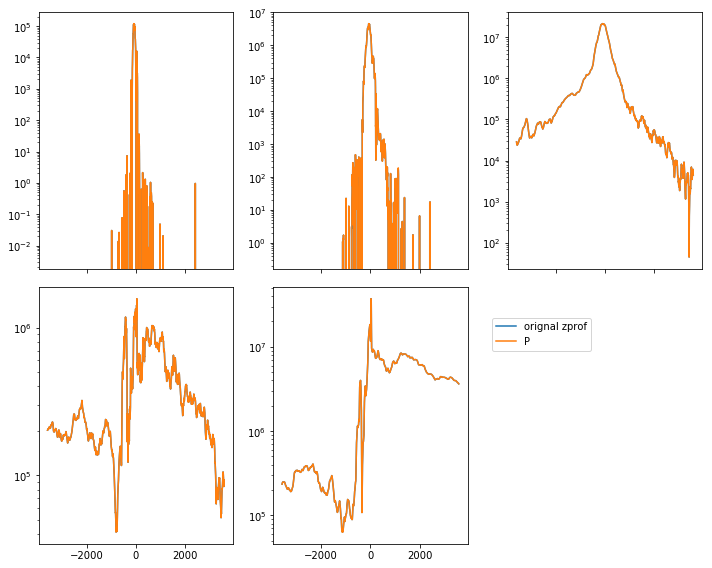

In [37]:
import pyathena.preprocessing as pre
import matplotlib.pyplot as plt

fig,axes=plt.subplots(2,3,figsize=(10,8),sharex=True)
field='P'
plist=['phase1','phase2','phase3','phase4','phase5']
for ph,ax in zip(plist,axes.flat):
    zp_orig,time=pre.read_zprof_one(base+pdir+'zprof/'+pid+'.0300.{}.zprof'.format(ph))
    ax.plot(zp_orig['z'],zp_orig[field],label='orignal zprof')
    ax.plot(zpdf.z,zpdf[field].sel(phase=ph))
    ax.set_yscale('log')
axes.flat[-1].axis('off')

plt.tight_layout()
ax.legend(loc='upper left',bbox_to_anchor=[1.1,0.9])

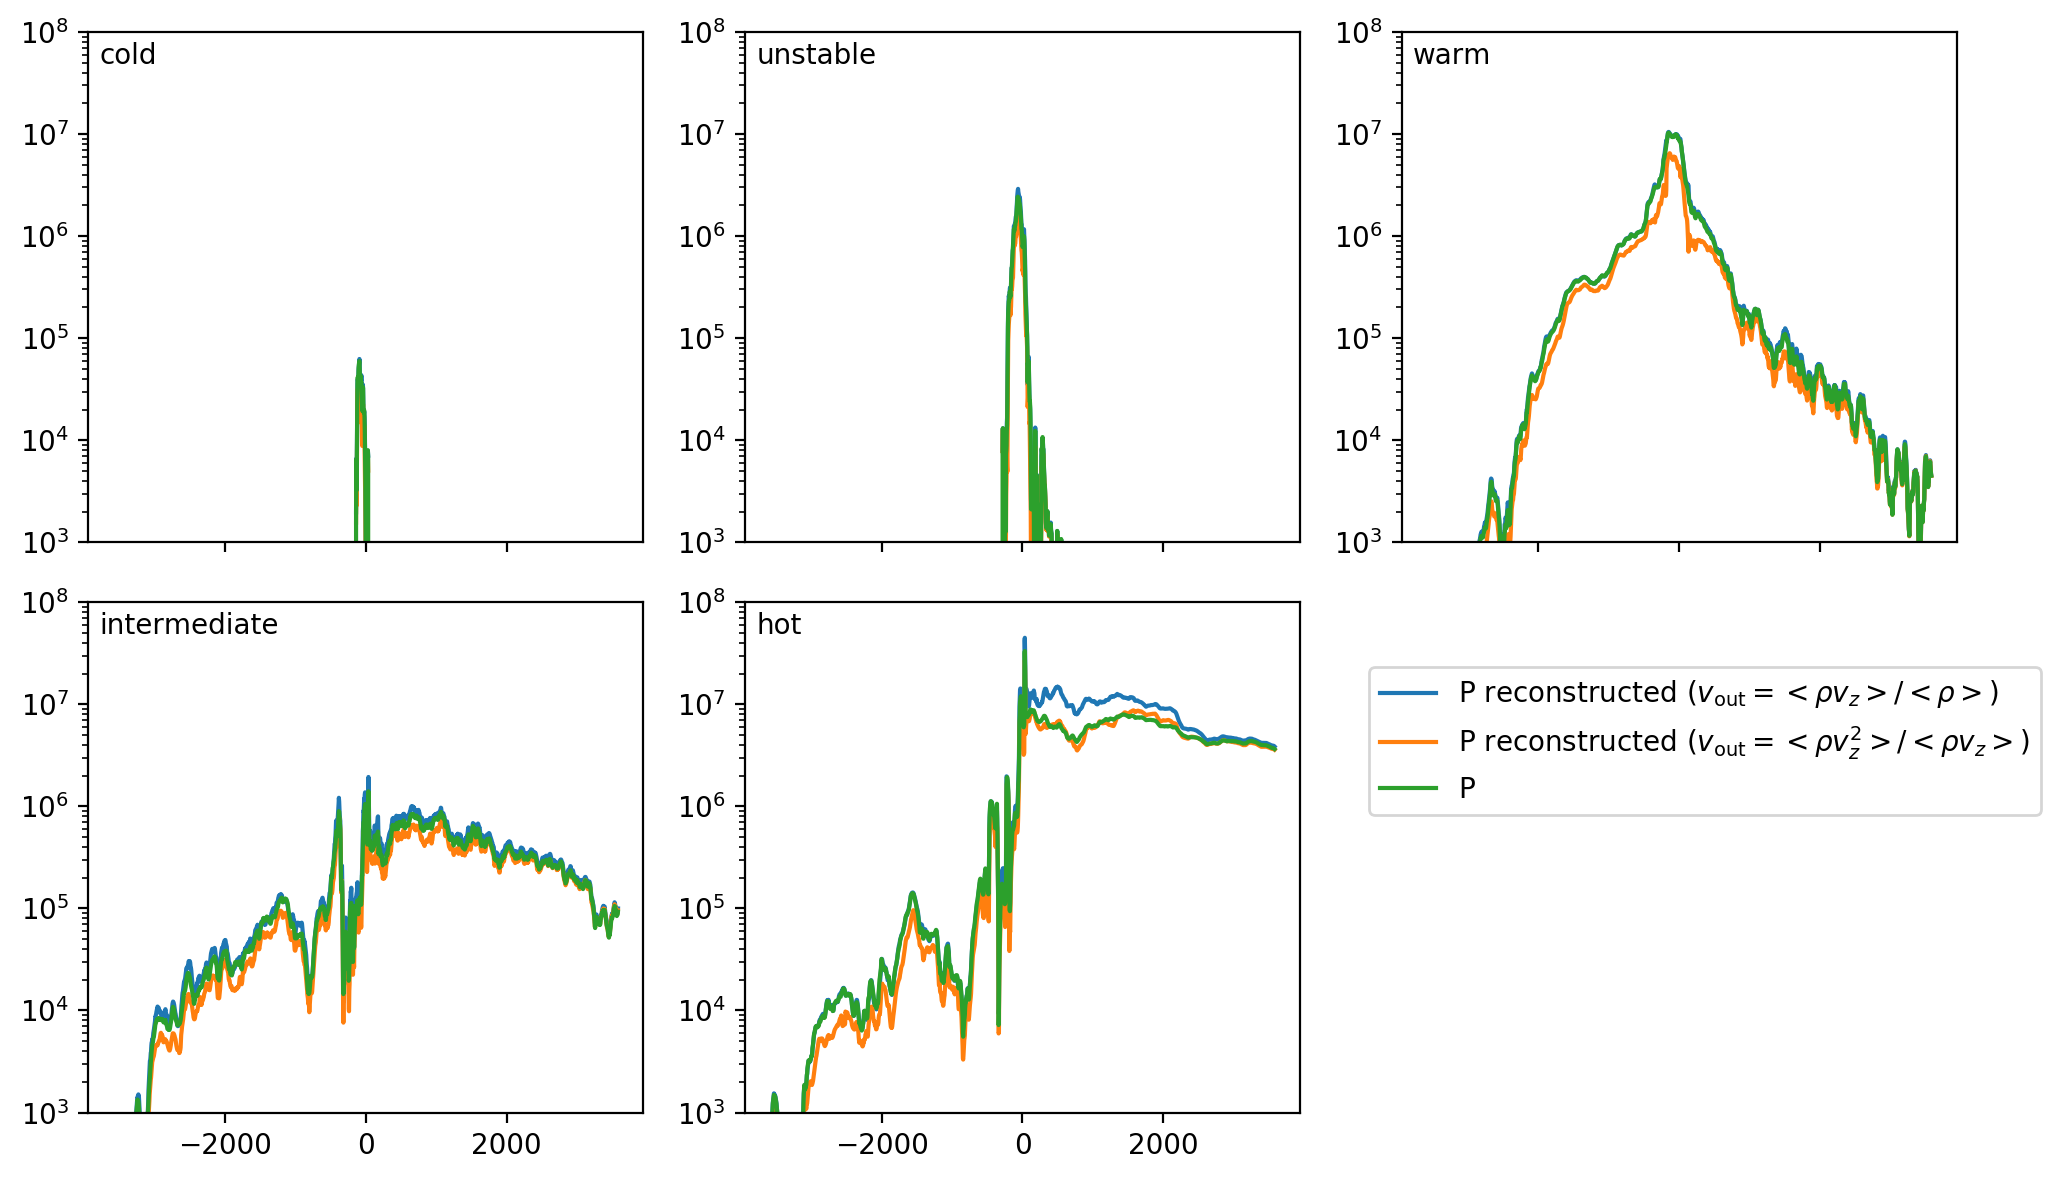

In [44]:
import pyathena.preprocessing as pre
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200
fig,axes=plt.subplots(2,3,figsize=(10,6),sharex=True)
field='pP'
plist=['phase1','phase2','phase3','phase4','phase5']
pname=['cold','unstable','warm','intermediate','hot']
for ph,pn,ax in zip(plist,pname,axes.flat):
    zp_orig,time=pre.read_zprof_one(base+pdir+'zprof/'+pid+'.0300.{}.zprof'.format(ph))
    pP=0.4*zp_orig['pFzP']*(zp_orig['pd']/zp_orig['pFzd'])
    ax.plot(zp_orig['z'],pP,label=r'P reconstructed $(v_{\rm out}=<\rho v_z>/<\rho>)$')
    pP=0.4*zp_orig['pFzP']*(zp_orig['pFzd']/zp_orig['pFzM3'])
    ax.plot(zp_orig['z'],pP,label=r'P reconstructed $(v_{\rm out}=<\rho v_z^2>/<\rho v_z>)$')
    ax.plot(zpdf.z,zpdf['pP'].sel(phase=ph),label='P')
#     mP=0.4*zp_orig['mFzP']*(zp_orig['md']/zp_orig['mFzd'])
#     ax.plot(zp_orig['z'],mP,label='mP reconstructed')
#     ax.plot(zpdf.z,zpdf['mP'].sel(phase=ph))

    ax.set_yscale('log')
    ax.set_ylim(1.e3,1.e8)
    ax.annotate(pn,(0.02,0.98),xycoords='axes fraction',ha='left',va='top')
axes.flat[-1].axis('off')

plt.tight_layout()
ax.legend(loc='upper left',bbox_to_anchor=[1.1,0.9])

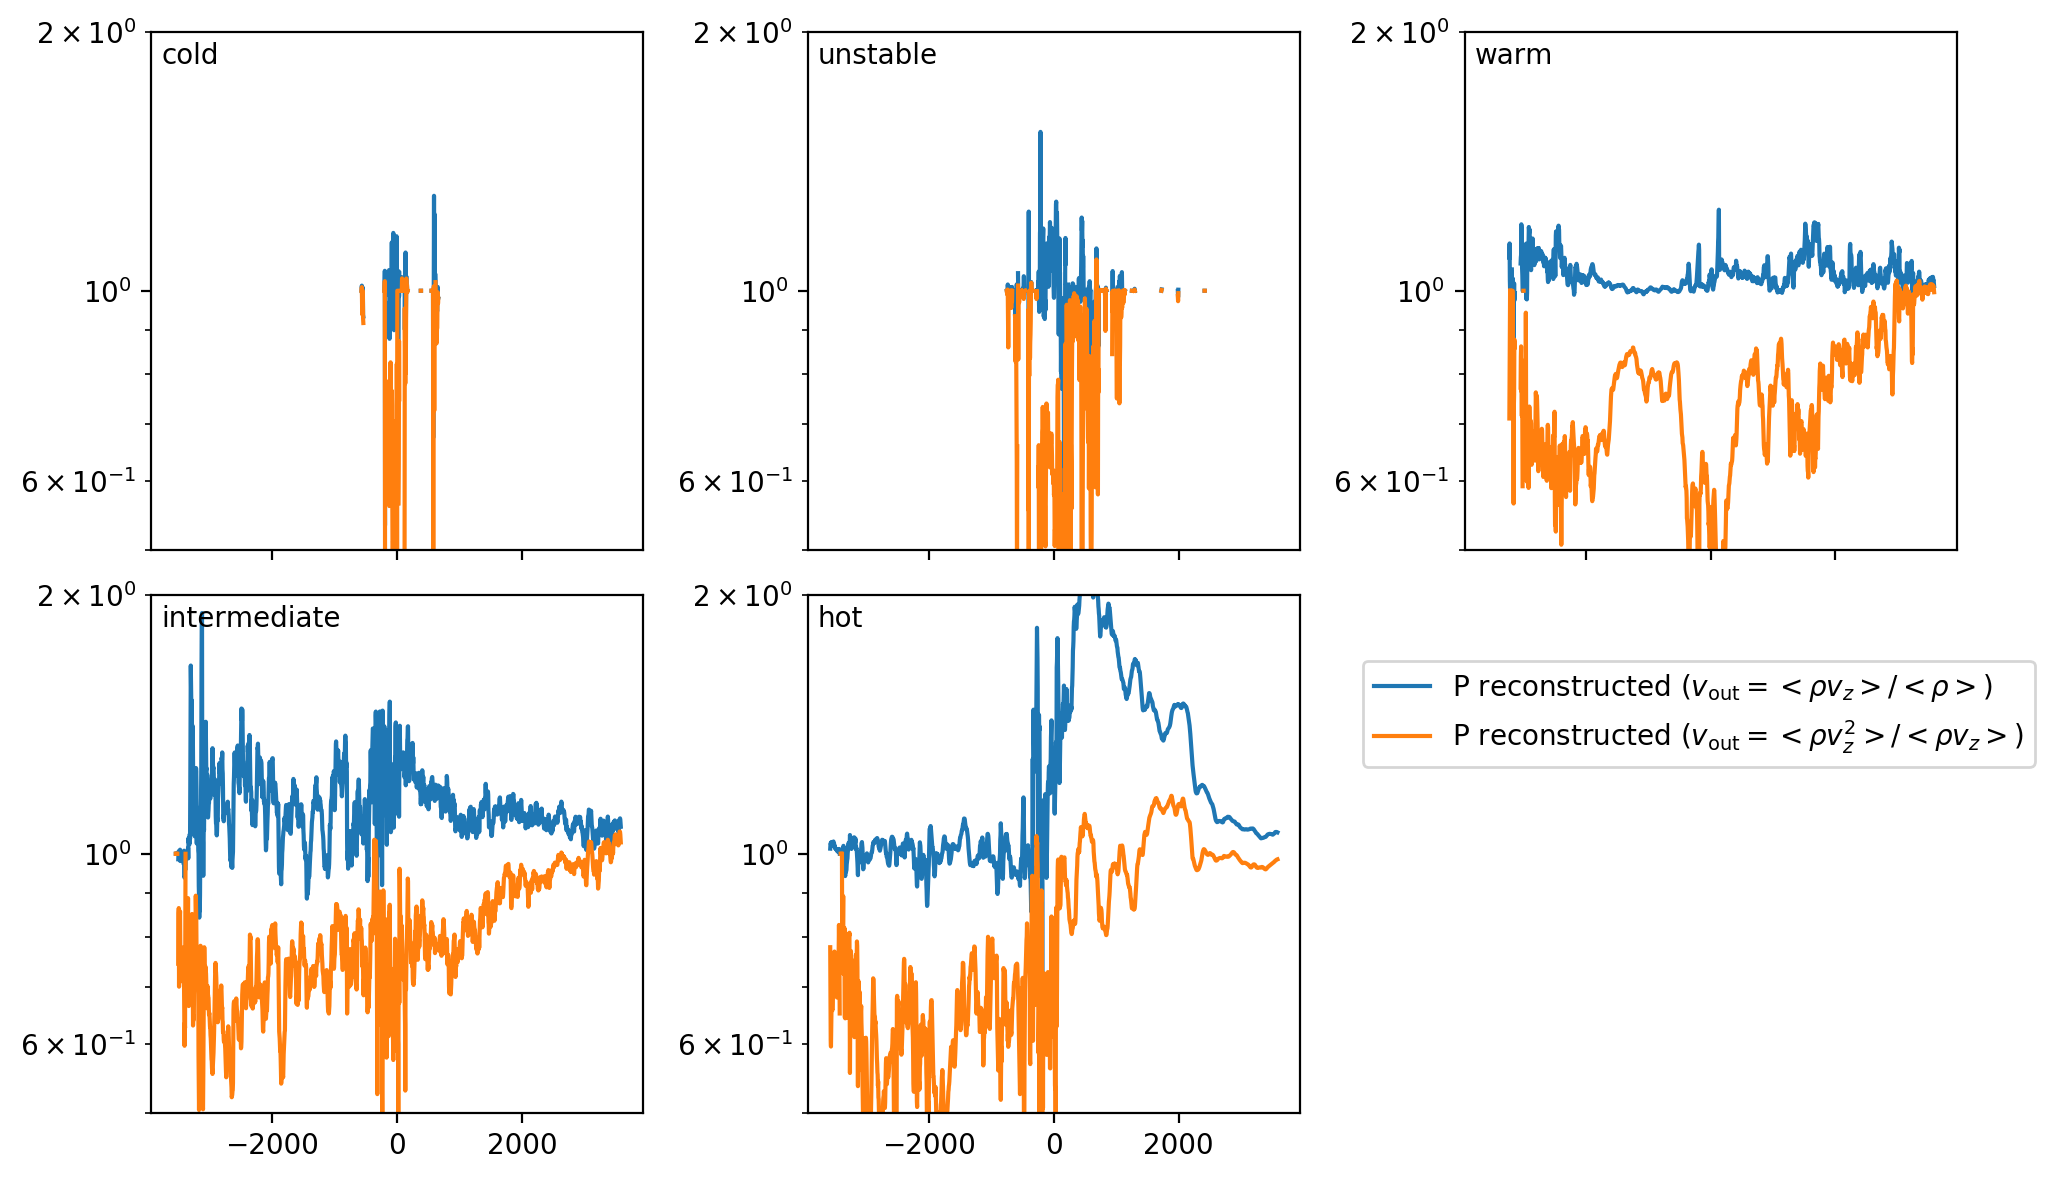

In [46]:
import pyathena.preprocessing as pre
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi']=200
fig,axes=plt.subplots(2,3,figsize=(10,6),sharex=True)
field='pP'
plist=['phase1','phase2','phase3','phase4','phase5']
pname=['cold','unstable','warm','intermediate','hot']
for ph,pn,ax in zip(plist,pname,axes.flat):
    zp_orig,time=pre.read_zprof_one(base+pdir+'zprof/'+pid+'.0300.{}.zprof'.format(ph))
    pP=0.4*zp_orig['pFzP']*(zp_orig['pd']/zp_orig['pFzd'])
    ax.plot(zp_orig['z'],pP/zpdf['pP'].sel(phase=ph),label=r'P reconstructed $(v_{\rm out}=<\rho v_z>/<\rho>)$')
    pP=0.4*zp_orig['pFzP']*(zp_orig['pFzd']/zp_orig['pFzM3'])
    ax.plot(zp_orig['z'],pP/zpdf['pP'].sel(phase=ph),label=r'P reconstructed $(v_{\rm out}=<\rho v_z^2>/<\rho v_z>)$')

#     mP=0.4*zp_orig['mFzP']*(zp_orig['md']/zp_orig['mFzd'])
#     ax.plot(zp_orig['z'],mP,label='mP reconstructed')
#     ax.plot(zpdf.z,zpdf['mP'].sel(phase=ph))

    ax.set_yscale('log')
    ax.set_ylim(0.5,2)
    ax.annotate(pn,(0.02,0.98),xycoords='axes fraction',ha='left',va='top')
axes.flat[-1].axis('off')

plt.tight_layout()
ax.legend(loc='upper left',bbox_to_anchor=[1.1,0.9])

### Below is a code to recalculate zprof from all the vtk files

In [ ]:
import os
import gc
pid_list=['R2_2pc_L512_B2_norun',
 'R4_2pc_L512_B10',
 'R8_4pc_newacc',
 'R16_8pc_metal',
 'LGR2_2pc_L512_B10',
 'LGR4_2pc_L512_B10',
 'LGR8_4pc_FUVcorr']

pid_list=['R2_4pc_L512_B2_norun',
 'LGR2_4pc_L512_B2_norun',
 'R4_4pc_L512_B2',
 'LGR4_4pc_L512_B10',
 'R8_8pc_newacc2',
 'LGR8_8pc_newacc',
 'R16_16pc_metal']
pid_list+=['R2_4pc_L256_B1','R2_4pc_L1024_B2_norun']

# pid_list=['LGR8_4pc_newacc']
# pid_list=['R8_16pc_newacc']
base='/tigress/changgoo/'
# plist=['phase1','phase2','phase3','phase4','phase5']

In [4]:
for pid in pid_list:
    pdir=pid + '/'

    outdir='zprof_P'
    if not os.path.isdir(base+pdir+outdir+'/'): os.mkdir(base+pdir+outdir)
    
    dc=data_container(pid,base=base,pdir=pdir)
    for f in dc.vtkfiles:
        dirname=base+pdir+outdir+'/'
        fbase=os.path.basename(f)
        zpf=dirname+fbase.replace('vtk','zprof.P.nc')
        if not os.path.isfile(zpf):
            zp=dump_zprof_one(f,dc)
            zp[['pP','mP']].to_netcdf(zpf)
            n=gc.collect()
            print('GC objects:',n)

In [5]:
import sys
sys.path.insert(0,'/tigress/changgoo/tigress-wind/python')
import data_container

In [20]:
for m in pid_list:

    with xr.open_mfdataset('/tigress/changgoo/{}/zprof_P/*.nc'.format(m),concat_dim='taxis',combine='nested') as dset:
        dset.to_netcdf('/tigress/changgoo/{}/zprof_merged/{}.P.zprof.nc'.format(m,m))
        dset.close()
        dc=data_container.data_container(m,create=True)

Reading a history file:/tigress/changgoo/R2_4pc_L512_B2_norun/hst/R2_4pc_L512_B2_norun.sn.p
Reading a history file:/tigress/changgoo/R2_4pc_L512_B2_norun/hst/R2_4pc_L512_B2_norun.hst.p
Merging zprof phases...
Creating flux files...
Reading a history file:/tigress/changgoo/LGR2_4pc_L512_B2_norun/hst/LGR2_4pc_L512_B2_norun.sn.p
Reading a history file:/tigress/changgoo/LGR2_4pc_L512_B2_norun/hst/LGR2_4pc_L512_B2_norun.hst.p
Merging zprof phases...
Creating flux files...
Reading a history file:/tigress/changgoo/R4_4pc_L512_B2/hst/R4_4pc_L512_B2.sn.p
Reading a history file:/tigress/changgoo/R4_4pc_L512_B2/hst/R4_4pc_L512_B2.hst.p
Merging zprof phases...
Creating flux files...
Reading a history file:/tigress/changgoo/LGR4_4pc_L512_B10/hst/LGR4_4pc_L512_B10.sn.p
Reading a history file:/tigress/changgoo/LGR4_4pc_L512_B10/hst/LGR4_4pc_L512_B10.hst.p
Merging zprof phases...
Creating flux files...
Reading a history file:/tigress/changgoo/R8_8pc_newacc2/hst/R8_8pc_newacc2.sn.p
Reading a history fi

In [7]:
import xarray as xr

In [8]:
dset=xr.open_dataarray('/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase1.zprof.nc')

In [9]:
dset

<xarray.DataArray (fields: 95, zaxis: 896, taxis: 550)>
[46816000 values with dtype=float64]
Coordinates:
  * fields   (fields) object 'z' 'A' 'd' 'v1' ... 'RxyL' 'RxyR' 'MxyL' 'MxyR'
  * zaxis    (zaxis) int64 -1790 -1786 -1782 -1778 -1774 ... 1778 1782 1786 1790
  * taxis    (taxis) float64 20.0 20.2 20.4 20.6 ... 129.2 129.4 129.6 129.8

In [11]:
from pyathena import preprocessing as pre

In [13]:
m

'R2_4pc_L512_B2_norun'

In [19]:
pre.zprof_to_xarray(base,m,m)

550 files have been merged. 11 will be appended
/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase1.zprof.nc is created
550 files have been merged. 11 will be appended
/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase2.zprof.nc is created
550 files have been merged. 11 will be appended
/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase3.zprof.nc is created
550 files have been merged. 11 will be appended
/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase4.zprof.nc is created
550 files have been merged. 11 will be appended
/tigress/changgoo/R2_4pc_L512_B2_norun/zprof_merged/R2_4pc_L512_B2_norun.phase5.zprof.nc is created


In [15]:
df,time=pre.read_zprof_one(base+m+'/zprof/'+m+'.0100.phase1.zprof')

In [18]:
df.columns.values

array(['z', 'A', 'd', 'v1', 'v2', 'v3', 'M1', 'M2', 'M3', 'Ek1', 'Ek2',
       'Ek3', 'P', 'T', 'dM2', 'dEk2', 'Phie', 'gext', 'dWext', 'Phisg',
       'gsg', 'dWsg', 'Ber', 'cool', 'heat', 'B1', 'B2', 'B3', 'PB1',
       'PB2', 'PB3', 'vA1', 'vA2', 'vA3', 'dB1', 'dB2', 'dB3', 'dPB1',
       'dPB2', 'dPB3', 'dvA1', 'dvA2', 'dvA3', 'S1', 'S2', 'S3', 's1',
       's2', 's3', 'pA', 'pd', 'pvz', 'pFzd', 'pFzM1', 'pFzM2', 'pFzM3',
       'pFzE1', 'pFzE2', 'pFzE3', 'pFzP', 'pFzEge', 'pFzEgsg',
       'pFzEtidal', 'pSzEm1', 'pSzEm2', 'pSzvB1', 'pSzvB2', 'pFzs1',
       'pFzs2', 'pFzs3', 'mA', 'md', 'mvz', 'mFzd', 'mFzM1', 'mFzM2',
       'mFzM3', 'mFzE1', 'mFzE2', 'mFzE3', 'mFzP', 'mFzEge', 'mFzEgsg',
       'mFzEtidal', 'mSzEm1', 'mSzEm2', 'mSzvB1', 'mSzvB2', 'mFzs1',
       'mFzs2', 'mFzs3', 'RxyL', 'RxyR', 'MxyL', 'MxyR'], dtype=object)